# ML-BASED LOAN APPLICATION VALIDATION: CODE OVERVIEW

## Summary

This codebook lies at the heart of automating **loan application validation**. There are five main things that happen in this architecture.

1. **Input:** You provide documents (PDF) and the applicant type (e.g. Service Holder).
2. **Classification:** Each page is labeled by a VL model (e.g. “this page is NID”, “this is Bank Statement”).
3. **Extraction:** For each document type, the model extracts key fields (names, numbers, amounts) into tables.
4. **Validation:** Data from the Loan Application Form is cross-checked with the supporting documents (e.g. NID number on form vs NID document).
5. **Output:** A validation table (Green / Yellow / Red / Missing) for a detailed deep dive, and an LM-generated executive summary of the main insights.

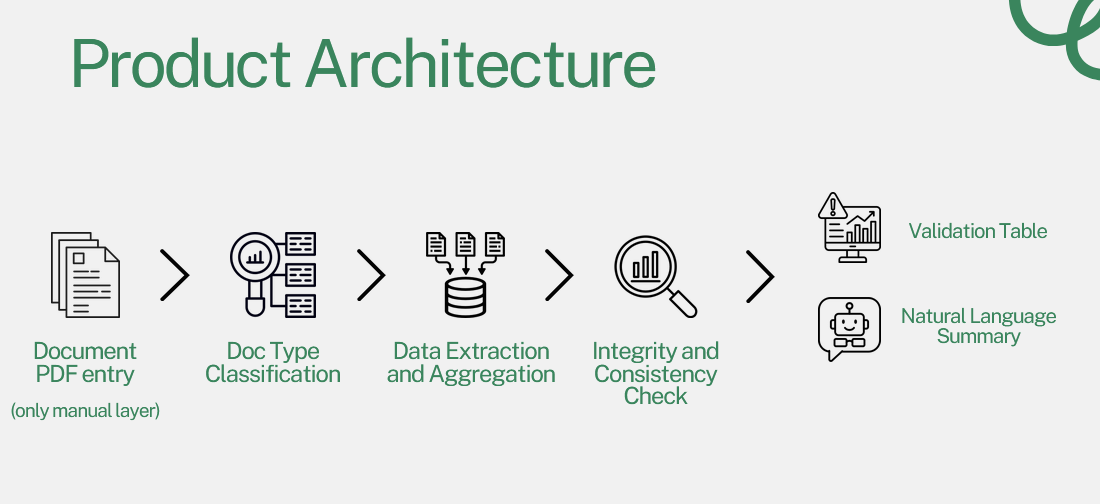

## Dataset

Due to lack of public information, the dataset had to be generated synthetically. First, fake identities, information and numbers were generated, corresponding to different fields in documents. Then those identities were aggregated, and samples from those were used to backtest and stress-test the code. The sample documents were generated using HTML, respecting the original document layouts that are found in Bangladesh. The Loan Application Form was loosely modeled around the fields found in Jamuna Bank Loan Application Form.

Each HTML file has an option to download the respective forms for each synthetic applicant.

While backtesting, I hand-wrote the application forms to also stress-test the model's capability to read handwritten data.

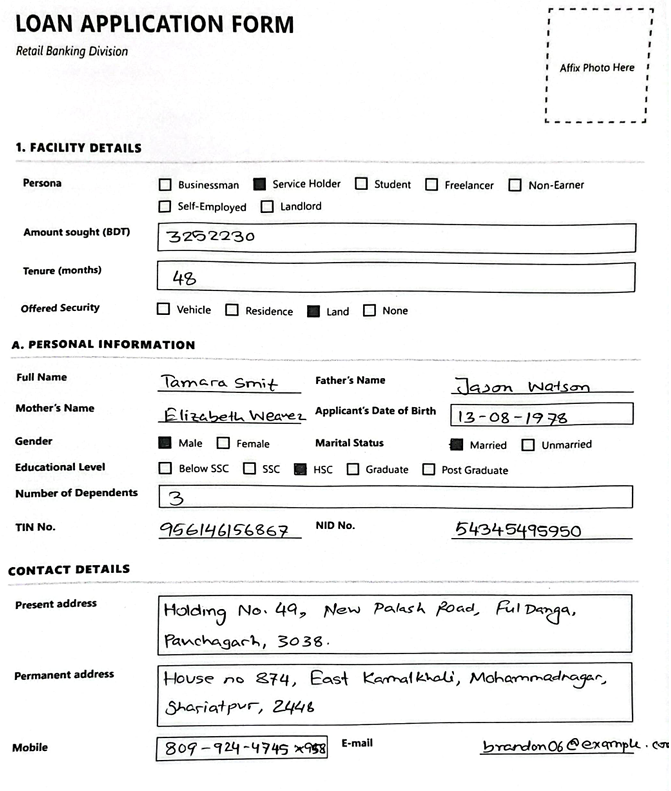

## System Requirements

A GPU with at least 16 GB VRAM is required to run this code. I have tried with lower parameter LLM models, but they yield lower quality outputs.

Moreover, 8GB RAM is recommended and at least 20-25GB space is required to make room for the LLM.

If your device does not meet this criteria, upload this document (and the input PDF) on Kaggle and use their cloud GPUs to run the code.

# Initialization

In [ ]:
# 1. INSTALLS (Kaggle cell)
!apt-get update && apt-get install -y poppler-utils
!pip install -q torch Pillow pandas git+https://github.com/huggingface/transformers qwen-vl-utils accelerate pdf2image bitsandbytes

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable InRelease [3,917 B]               
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.0 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,361 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:10 https://cli.github.com/packages stable/main amd64 Packages [356 B]      
Get:11 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [62.6 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main 

In [ ]:
import torch, gc
from PIL import Image
from pdf2image import convert_from_path
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from qwen_vl_utils import process_vision_info
import re
import pandas as pd
from difflib import SequenceMatcher

# Loading the model

The LLM used here is a **vision-language model** named Qwen. The initial idea was to work with OCR-based models (e.g. Paddle OCR VL), but LLMs like Qwen are pre-equipped with the capacity to understand language and contexts in a much sophisticated manner, reducing error probability.

The Qwen model comes with visual receptor to process and understand both high-resolution images and text. It excels at tasks like fine-grained visual recognition, document parsing, and grounding, making it ideal for extracting structured data from complex documents like loan applications.

Here, the model is loaded with certain features and optimization:

1. To ensure the model does not overcook existing GPU capacity, 4-bit-quantization was turned on. It compresses the model's weight precision from 32-bit floating points to 4-bit integer.
2. We also load the “processor” that prepares images and text for the model. This step can take a few minutes the first time.
3. torch_dtype=torch.bfloat16: Uses 16 bits per parameter instead of the standard 32 bits, reducing VRAM usage to half.

In [ ]:
# 2. QUANTIZED MODEL LOADING
model_id = "Qwen/Qwen2.5-VL-7B-Instruct"

# 4-bit config optimized for T4 GPUs (Kaggle)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 # Ensures computation happens in BF16
)

print("Loading model...")

# Added torch_dtype and revised the loading call
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16, # Vital for Qwen2.5-VL precision
)

processor = AutoProcessor.from_pretrained(model_id)
print("Model and Processor loaded successfully!")

Loading model...


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/729 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Model and Processor loaded successfully!


# STEP 1: CLASSIFICATION OF DOCUMENTS

To make life easier for bankers, the document classification was left to the LLM model.

We define which document types the applicant must submit based on their “persona” (e.g. Service Holder, Self Employed, Businessman). For example, a Service Holder must provide NID, TIN, Loan Application Form, Utility Bill, Bank Statement, Pay Slip, and Employee ID. This list is used later to check if any required document is missing.

In [ ]:
# PERSONA LOGIC
def get_persona_categories(persona):
    common = ["NID", "TIN", "Loan Application Form", "Utility Bill", "Bank Statement"]
    mapping = {
        "Service Holder": common + ["Pay Slip", "Employee ID"],
        "Self Employed": common + ["Professional Certificate"],
        "Businessman": common + ["Trade License"]
    }
    return mapping.get(persona, common + ["Other"])

This function takes a PDF and the applicant’s persona, converts each PDF page to an image, and sends all pages to the vision-language model. The model returns a label for each page (e.g. “Page 1: TIN”, “Page 2: Utility Bill”). So we get a list of (page number, document type) for the whole PDF.

There are two strategic reasons for picking Scanned PDF as the input format:

1. Most Bangladeshi professionals are incredibly comfortable with apps like CamScanner. It is a simple, easy tool to aggregate image-based documents.
2. Top scanning-to-PDF apps automatically deskew the image and increase document readability. (Even if that weren't the case, there are Python libraries to improve photo clarity.)

The UI for this part looks something like: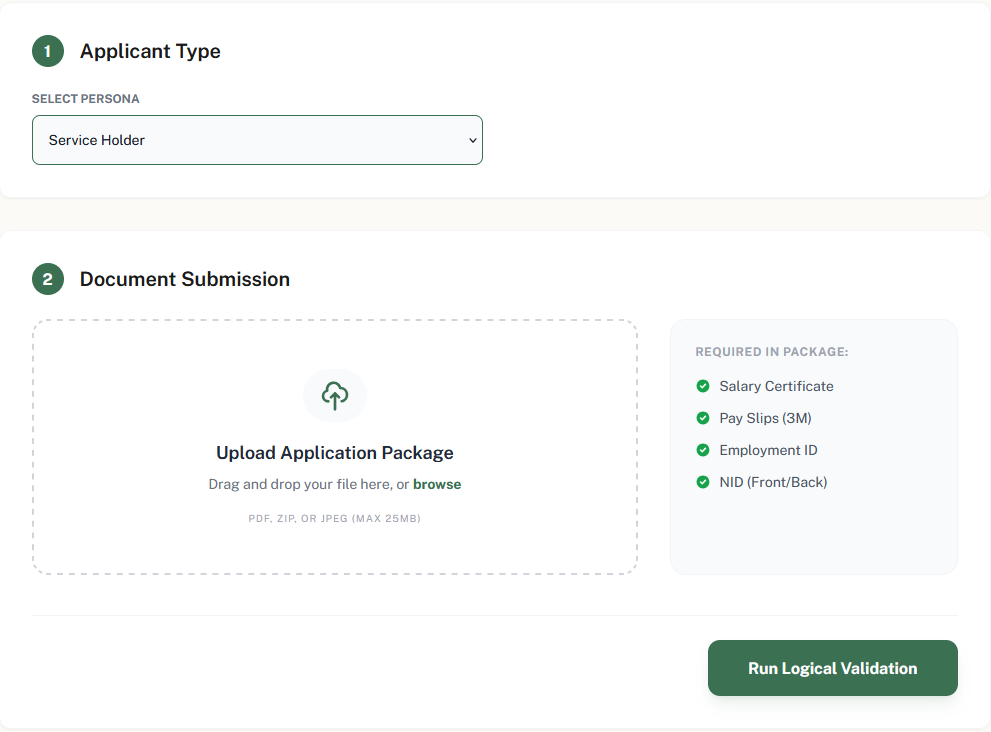

In [ ]:
def classify_doc_with_pages(pdf_path, persona):
    images = convert_from_path(pdf_path)
    categories = get_persona_categories(persona)

    # Indexed content list
    content_list = []
    for i, img in enumerate(images):
        page_num = i + 1
        content_list.append({
            "type": "image",
            "image": img,
            "max_pixels": 512 * 512
        })
        # We add a text identifier for the model to "see" which image is which
        content_list.append({"type": "text", "text": f"This is Page {page_num}."})

    # Targeted Prompt
    prompt = (
        "Persona: {persona}. I have provided {len(images)} pages from a document. Your task is to classify each page into one of the following categories: [TIN, Utility Bill, Loan Application Form, Pay Slip, NID, Bank Statement]. Follow these specific classification rules: identify a TIN by 'Taxpayer's Identification Number' or 'TIN Certificate' ; a Utility Bill by 'Electricity Bill,' 'Power Development Board,' or similar utility terms ; a Loan Application Form by 'Loan Application Form' or sections like 'Employment Details' and 'Financial Information' ; a Pay Slip by 'PAYSLIP,' 'Earnings,' 'Deductions,' or 'Net Payable Amount' ; an NID by 'National ID Card' or 'জাতীয় পরিচয়পত্র' ; and a Bank Statement by 'Account Statement' or 'Statement of Accounts' containing a transaction table with 'Withdraw,' 'Deposit,' and 'Balance' columns. Format your response exactly as 'Page 1: [Category]' for every page and return ONLY the formatted list."
    )
    content_list.append({"type": "text", "text": prompt})

    messages = [{"role": "user", "content": content_list}]

    # Inference
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(messages)
    inputs = processor(text=[text], images=image_inputs, padding=True, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=100) # Increased tokens for the list
    generated_ids = [out[len(ins):] for ins, out in zip(inputs.input_ids, output_ids)]
    raw_output = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    return raw_output, images

We run the classifier on a sample PDF of a synthetically generated applicant.

If you are running the code on Kaggle, use the full path of the PDF in the coding environment.

If you are running the code on Google Colab, just insert the PDF file name.

If you are running the code locally, use the path of the PDF. Here, by default, it is assumed that the code and the pdf are in the same folder (that is how it is submitted).

In [ ]:
output = classify_doc_with_pages('loantest_v3.pdf', "Service Holder")
print(output)

('Page 1: TIN\nPage 2: Utility Bill\nPage 3: Loan Application Form\nPage 4: Loan Application Form\nPage 5: Loan Application Form\nPage 6: Loan Application Form\nPage 7: Pay Slip\nPage 8: NID\nPage 9: Bank Statement', [<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1653x2339 at 0x7BAB739F61E0>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2339x1653 at 0x7BABA6DE12E0>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1653x2339 at 0x7BABA6DE1430>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1653x2339 at 0x7BABA6DE18E0>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1653x2339 at 0x7BABA6DE1460>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2339x1653 at 0x7BABA6DE1910>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1653x2339 at 0x7BABA6DE1490>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2339x1653 at 0x7BABA6DE1940>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1653x2339 at 0x7BABA6DE14C0>])


Here, the outputs can be seen. The document types are tagged against their page numbers in the PDF.

# STEP 2: EXTRACTION OF DATA FROM DOCUMENTS

This is a small helper function that clears GPU memory after each LLM activity. We call this between document extractions so the GPU does not run out of memory when processing many pages.

In [ ]:
def clear_gpu():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    alloc = torch.cuda.memory_allocated() / 1024**2 if torch.cuda.is_available() else 0
    reserv = torch.cuda.memory_reserved() / 1024**2 if torch.cuda.is_available() else 0
    print("--- GPU RESET ---")
    print(f"Allocated: {alloc:.2f} MB")
    print(f"Reserved:  {reserv:.2f} MB")
    print("-----------------")

For each document type (NID, TIN, Bank Statement, Pay Slip, etc.) we define the **prompts** for the model.

Prompt engineering was a crucial part of this project. A precise balance needs to be struck between a few factors:
1. Context: Too much context may result in context overload. Too little makes the outcome prone to solely the LLM's understanding of inputs, which is often wrong.
2. Specificity: Specific instructions (e.g. keywords, document shape) helped the models not confuse between Pay Slip and Bank Statement, for example. However, hard-coding instructions can be a bad idea for documents of varying types. For example, Bank Statement layouts can be different, so a prompt suggesting an ultra-specific structure will fail on statements not following that structure. Lastly, there is scope for confusion - if I say that you will find 'NID Number' in NID, it will confuse the model because there is NID Number in Loan Application as well.

**The trick is to feed the prompt with the most uniquely important and visible identifiers.**

In [ ]:
def get_prompt(doc_type):
    doc_type = (doc_type or "").strip()
    # Bank Statement: structural reconstruction + AccName, AccNo headers
    if "bank statement" in doc_type.lower():
        return (
            "Extract data from this bank statement image. "
            "First output two header lines: GT_Doc_Statement_AccName: [account holder name], then GT_Doc_Statement_AccNo: [account number]. "
            "Then output a Markdown table with exactly these columns: | Date | Description | Debit | Credit | Balance |. "
            "One row per transaction. Use empty cells where a value is not applicable. Return only the headers and the table in Markdown."
        )

    if "loan application" in doc_type.lower():
        return "Extract key fields into a Markdown table | Field | Value |. (Loan form handled separately.)"
    # NID (cite: 100, 101)
    if doc_type.upper() == "NID":
        return (
            "Extract ALL of the following from this NID document. Output a Markdown table with columns: | Field | Value |. "
            "You MUST include exactly these 3 rows:\n"
            "- GT_Doc_NID_Name: The full name on the NID\n"
            "- GT_Doc_NID_No: The NID number\n"
            "- GT_Doc_NID_DOB: The date of birth shown on the NID\n"
            "Return only the table. Every row is mandatory."
        )

    if doc_type.upper() == "TIN":
        return (
            "Extract ALL of the following from this TIN certificate. Output a Markdown table with columns: | Field | Value |. "
            "You MUST include exactly these 2 rows:\n"
            "- GT_Doc_TIN_Name: The full name of the person on the TIN certificate\n"
            "- GT_Doc_TIN_Number: The TIN number (12-digit number)\n"
            "Return only the table. Every row is mandatory."
        )

    if "trade license" in doc_type.lower():
        return (
            "Extract from this Trade License. Output a Markdown table with columns: | Field | Value |. "
            "Rows: GT_Doc_TradeLicense_OrgName, GT_Doc_TradeLicense_LicenseNo. Return only the table."
        )

    if "utility bill" in doc_type.lower():
        return (
            "Extract ALL of the following from this Utility Bill. Output a Markdown table with columns: | Field | Value |. "
            "You MUST include exactly these 2 rows:\n"
            "- GT_Doc_Utility_Name: The customer/subscriber name who was billed\n"
            "- GT_Doc_Utility_Address: The service address or customer address on the bill\n"
            "Return only the table. Every row is mandatory."
        )

    if "pay slip" in doc_type.lower() or "payslip" in doc_type.lower():
        return (
            "Extract ALL of the following from this Pay Slip. Output a Markdown table with columns: | Field | Value |. "
            "You MUST include exactly these 2 rows:\n"
            "- GT_Doc_Payslip_EmployerName: The employer or company name on the payslip\n"
            "- GT_Doc_Payslip_NetPay: The net pay / take-home amount (the final amount after deductions)\n"
            "Return only the table. Every row is mandatory."
        )

    if "employee id" in doc_type.lower():
        return (
            "Extract from this Employee ID. Output a Markdown table with columns: | Field | Value |. "
            "Rows: GT_Doc_EmpID_No, GT_Doc_EmpID_OrgName, GT_Doc_EmpID_Designation, GT_Doc_EmpID_Name. Return only the table."
        )

    if "professional certificate" in doc_type.lower():
        return (
            "Extract from this Professional Certificate. Output a Markdown table with columns: | Field | Value |. "
            "Rows: GT_Doc_ProfCert_BodyName, GT_Doc_ProfCert_RegNo, GT_Doc_ProfCert_Name. Return only the table."
        )

The classifier then returns text like “Page 1: TIN\nPage 2: Utility Bill”. This function parses that text into a list of (page index, document type) pairs so we can loop over each page and run the right extraction for that type.

In [ ]:
def parse_classification_output(raw_output):
    """Parse 'Page 1: [Category]\\nPage 2: [Category]' into list of (page_index_0based, doc_type)."""
    queue = []
    for line in raw_output.strip().split("\n"):
        m = re.match(r"Page\s+(\d+)\s*:\s*\[?(.+?)\]?\s*$", line.strip(), re.I)
        if m:
            page_num = int(m.group(1))
            doc_type = m.group(2).strip()
            queue.append((page_num - 1, doc_type))  # 0-based index
    return queue

The model returns extracted data as Markdown tables (e.g. | Field | Value |). This function finds those tables in the text and converts them into pandas DataFrames so we can work with the data in Python (filter, compare, and validate).

In [ ]:
def markdown_tables_to_dataframes(md_text):
    """Parse Markdown tables from raw model output into list of Pandas DataFrames (regex-based)."""
    if not md_text or not md_text.strip():
        return []
    tables = []

    table_block = re.findall(
        r"(\|[^\n]+\|\s*\n\|[-:\s|]+\|\s*\n(?:\|[^\n]+\|\s*\n?)*)",
        md_text
    )
    for block in table_block:
        lines = [ln.strip() for ln in block.strip().split("\n") if ln.strip().startswith("|")]
        if len(lines) < 2:
            continue
        header = [c.strip() for c in lines[0].split("|")[1:-1]]
        rows = []
        for ln in lines[2:]:  # skip header and separator
            cells = [c.strip() for c in ln.split("|")[1:-1]]
            if len(cells) == len(header):
                rows.append(cells)
            elif len(cells) > 0:
                rows.append(cells[:len(header)] + [""] * (len(header) - len(cells)))
        if header:
            tables.append(pd.DataFrame(rows, columns=header))
    return tables

Here, we identify the missing documents.

In [ ]:
try:
    classification_raw, images = output
    queue = parse_classification_output(classification_raw)
except NameError:
    queue = []
    images = []

def doc_type_to_results_key(doc_type):
    d = (doc_type or "").strip().lower()
    if "nid" == d: return "NID"
    if "tin" == d: return "TIN"
    if "bank statement" in d: return "Bank Statement"
    if "loan application" in d: return "Loan Application Form"
    if "trade license" in d: return "Trade License"
    if "utility bill" in d: return "Utility Bill"
    if "pay slip" in d or "payslip" in d: return "Pay Slip"
    if "employee id" in d: return "Employee ID"
    if "professional certificate" in d: return "Professional Certificate"
    return "Other"

results = {
    "NID": [], "TIN": [], "Bank Statement": [], "Loan Application Form": [],
    "Trade License": [], "Utility Bill": [], "Pay Slip": [], "Employee ID": [],
    "Professional Certificate": [], "Other": []
}

# --- Missing document check (before extraction; uses classification queue) ---
try:
    _ = persona
except NameError:
    persona = "Service Holder"  # set to match the persona you used for classification
expected = get_persona_categories(persona)
found = {doc_type_to_results_key(doc_type) for _, doc_type in queue}
missing = [d for d in expected if d not in found]
if missing:
    print(f"Persona: {persona}")
    print("Missing document type(s):")
    for d in missing:
        print(f"  - {d} is missing")
else:
    print(f"Persona: {persona}")
    print("All expected document types present.")


Persona: Service Holder
Missing document type(s):
  - Employee ID is missing


Here, we define which fields are mandatory for each document type (e.g. NID must have name, number, DOB). The main function here runs the vision model on one image to extract data. If mandatory fields are missing, it retries once at higher resolution to improve accuracy. Each extracted table is tagged with the source page and document type.

The retry functions were added due to a difficulty I was facing with extracting certain information. In a polished code, it is unlikely to be required.

In [ ]:
# --- Mandatory field registry per doc type (for retry logic) ---
MANDATORY_FIELDS = {
    "NID":          ["nid_name", "nid_no", "nid_dob"],
    "TIN":          ["tin_name", "tin_number"],
    "Utility Bill": ["utility_name", "utility_address"],
    "Pay Slip":     ["payslip_employername", "payslip_netpay"],
}

def _check_mandatory(dfs, doc_type):
    """Return list of mandatory field substrings that are MISSING from dfs."""
    expected = MANDATORY_FIELDS.get(doc_type, [])
    if not expected:
        return []
    found_fields = set()
    for df in dfs:
        if "Field" in df.columns:
            for _, row in df.iterrows():
                found_fields.add(str(row["Field"]).lower())
    missing = []
    for mf in expected:
        if not any(mf in f for f in found_fields):
            missing.append(mf)
    return missing

def _vlm_extract(image, prompt, max_pixels, min_pixels, max_new_tokens):
    """Single VLM call for extraction; returns raw markdown string."""
    content_list = [
        {"type": "image", "image": image, "max_pixels": max_pixels, "min_pixels": min_pixels},
        {"type": "text", "text": prompt}
    ]
    messages = [{"role": "user", "content": content_list}]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(messages)
    inputs = processor(text=[text], images=image_inputs, padding=True, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [out[len(ins):] for ins, out in zip(inputs.input_ids, output_ids)]
    raw_md = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    del inputs, output_ids, generated_ids, image_inputs
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return raw_md

def run_single_extraction(image, doc_type, source_page):
    """Run VLM on one image; return raw_md and list of DataFrames with Source_Page and Doc_Type.
    Includes per-field retry: if mandatory fields are missing, retries at higher resolution."""
    dt = doc_type.lower()
    is_heavy = "bank statement" in dt
    # Higher res for small docs so fine text is readable; bank statements get full res
    max_pixels = 1024 * 1024 if is_heavy else 768 * 768
    min_pixels = 512*28*28
    max_new_tokens = 4000 if is_heavy else 1024

    prompt = get_prompt(doc_type)
    raw_md = _vlm_extract(image, prompt, max_pixels, min_pixels, max_new_tokens)
    dfs = markdown_tables_to_dataframes(raw_md)

    # --- Retry if mandatory fields are missing (once, at higher res) ---
    missing = _check_mandatory(dfs, doc_type)
    if missing and not is_heavy:
        missing_str = ", ".join(missing)
        print(f"  [Retry] Missing mandatory fields ({missing_str}). Retrying at higher resolution...")
        retry_max_px = 1024 * 1024
        retry_prompt = (
            f"IMPORTANT: The following fields were NOT found in a previous attempt: {missing_str}. "
            f"You MUST extract them this time. Look carefully at the entire document.\n\n{prompt}"
        )
        raw_md2 = _vlm_extract(image, retry_prompt, retry_max_px, min_pixels, max_new_tokens)
        dfs2 = markdown_tables_to_dataframes(raw_md2)
        still_missing = _check_mandatory(dfs2, doc_type)
        if len(still_missing) < len(missing):
            print(f"  [Retry] Improved: recovered {len(missing) - len(still_missing)} field(s).")
            raw_md = raw_md2
            dfs = dfs2
        else:
            print(f"  [Retry] No improvement; keeping original output.")

    for df in dfs:
        df["Source_Page"] = source_page
        df["Doc_Type"] = doc_type
    return raw_md, dfs

Given the Loan Application Form is quite a task with above 50 extractable information and multiple sections (Applicant Details, Employment, Financials, Banking), I decided to handle it differently. I have defined a prompt and field list for each section and a function that runs the model on each form page. The results from all pages are merged into one table for use in validation.

This is a perfect example of when **hard-coded prompts** are valid. A bank's loan form layout does not change in short notice, so linking sections to pages was a valid move, alongside specifying exactly what data can be found from where.

Another optimization I have done throughout is to set a **photo resolution ceiling**. The VRAM usage generally explodes when the model deals with high-resolution images (1080p and above). After backtesting, I settled for 720 * 28 * 28 as my image processing format. This means the model will batch 720 images from the input, each having 28*28 resolution, to make processing easier.

In [ ]:
# ============================================================
# CONFIGURATION & TEMPLATES
# ============================================================

PROMPT_TEMPLATE = (
    "You are an expert data extraction engine specializing in financial documents. "
    "Your task is to extract data from the provided image of a Loan Application Form "
    "(Page {page_number}) corresponding to {section_name} into a Markdown table "
    "with the header | Field | Value |. "
    "You must follow these strict extraction rules: extract data exactly as it appears "
    "in the document (including currency symbols, dates, and address formatting), "
    "but do not hallucinate or include any fields that are blank, marked as 'N/A', "
    "or not explicitly visible on this specific page. "
    "Only extract the fields listed for this page: {fields_list}. "
    "Return ONLY the Markdown table and nothing else—no introductory text, "
    "closing remarks, or conversational filler."
)

LOAN_FORM_MAX_PIXELS = 720 * 28 * 28

# Mapping relative page index (1-4) to section keys
PAGE_TO_SECTION_MAP = {
    1: "A",  # Applicant Details
    2: "B",  # Employment
    3: "D",  # Financials (Merged C & D)
    4: "E"   # Banking & References
}

LOAN_FORM_SECTIONS = {
    "A": {
        "name": "Applicant Details & Loan Info",
        "fields_list": (
            "SL, Persona, Amount sought (BDT), Tenure (Months), Offered Security, "
            "Applicant Name, Father's Name, Mother's Name, Marital Status, "
            "Applicant's Date of Birth, Gender, Educational Level, Number of Dependents, "
            "TIN No., NID No., Present Address, Permanent Address, Mobile, E-mail."
        ),
        "max_tokens": 500,
    },
    "B": {
        "name": "Employment & Business",
        "fields_list": (
            "Name of Present Employer, Designation, Date of Joining (Present Employer), "
            "Profession (Self-Employed), No. of years in Practice, Clinic/Chamber/Firm/Office Name, "
            "Organization Name (Businessman), Organization Address (Businessman), "
            "Years in Present Business, Total Length of Business."
        ),
        "max_tokens": 350,
    },
    "D": {
        "name": "Financial Information (Income, Expenditure, Assets & Liabilities)",
        "fields_list": (
            "Monthly Income (Salary, Business, Rental, Interest, Other, Total X), "
            "Monthly Expenditure (Loan repayment, Cards, Rent/Utilities, Living, "
            "Educational, Other, Total Y), Uncommitted Income (X-Y), "
            "Assets (Savings, Current, Fixed Deposit, Bonds, Shares, Land/Building, "
            "Vehicles, Business Investment, Precious Metals, Total Assets), "
            "Liabilities (Bank Loans, Credit Cards, Other, Total Liability, Net Worth)."
        ),
        "max_tokens": 700,
    },
    "E": {
        "name": "Banking, Credit Cards & References",
        "fields_list": (
            "Bank Name, Branch, Account No., Type, Average Balance, "
            "Lender Name, Branch, Account No., Amount Outstanding, Monthly Repayment, "
            "Has Credit Card, Issuing Institution, Card No., Limit, Outstanding, "
            "Reference Name, Relationship, Address, Phone, Profession, Email."
        ),
        "max_tokens": 500,
    },
}

# ============================================================
# HELPER FUNCTIONS
# ============================================================

def _vlm_call(image, prompt_text, max_new_tokens, max_pixels=720*28*28):
    """
    Low-level single VLM call. Returns raw decoded string.
    Uses max_pixels to resize image and limit GPU memory (critical for OOM avoidance).
    """
    content_list = [
        {"type": "image", "image": image, "max_pixels": max_pixels},
        {"type": "text", "text": prompt_text},
    ]
    messages = [{"role": "user", "content": content_list}]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)

    generated_ids = [out[len(ins):] for ins, out in zip(inputs.input_ids, output_ids)]
    out_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    del inputs, output_ids, generated_ids, image_inputs
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return out_text

def extract_loan_page_data(image, page_index):
    """
    Constructs the prompt and extracts data for a specific page index.
    """
    # 1. Identify Section
    section_key = PAGE_TO_SECTION_MAP.get(page_index)
    if not section_key:
        print(f"  [Warning] No section map found for relative page {page_index}. Skipping.")
        return None, []

    section_config = LOAN_FORM_SECTIONS[section_key]

    # 2. Build Deterministic Prompt
    final_prompt = PROMPT_TEMPLATE.format(
        page_number=page_index,
        section_name=section_config["name"],
        fields_list=section_config["fields_list"]
    )

    # 3. Call VLM (with capped image size to avoid OOM)
    print(f"  Targeting Section {section_key}: {section_config['name']}")
    raw_md = _vlm_call(image, final_prompt, section_config["max_tokens"], max_pixels=LOAN_FORM_MAX_PIXELS)

    # 4. Parse Table
    # (Assuming markdown_tables_to_dataframes is available in your utils)
    dfs = markdown_tables_to_dataframes(raw_md)
    rows = []
    for df in dfs:
        if not df.empty and "Field" in df.columns and "Value" in df.columns:
            rows.extend(df.to_dict("records"))

    return raw_md, rows

# ============================================================
# MAIN PIPELINE
# ============================================================

def run_loan_form_extraction(loan_pages):
    """
    Deterministic pipeline for Loan Application Form pages.
    loan_pages: list of (source_page_number, PIL_image)

    NOTE: We iterate with a relative index (1, 2, 3, 4) to map to sections,
    regardless of the absolute page number in the original PDF.
    """
    all_raw = []
    all_rows = []

    print(f"Starting Deterministic Extraction on {len(loan_pages)} pages...")

    # enumerate start=1 gives us the relative index (1st page, 2nd page, etc.)
    for relative_idx, (source_page_num, image) in enumerate(loan_pages, start=1):
        print(f"\n{'='*60}")
        print(f"Processing Loan Form Page {relative_idx} (Original PDF Page {source_page_num})")
        print(f"{'='*60}")

        try:
            raw_md, rows = extract_loan_page_data(image, relative_idx)
        except torch.cuda.OutOfMemoryError:
            print(f"  OOM on page {relative_idx} — skipping. Clearing GPU...")
            clear_gpu()
            continue

        if raw_md:
            section_name = LOAN_FORM_SECTIONS[PAGE_TO_SECTION_MAP[relative_idx]]["name"]
            header = f"--- Page {source_page_num} (Form Page {relative_idx}) | {section_name} ---"
            all_raw.append(f"{header}\n{raw_md}")
            print("  Raw markdown (this page):")
            print(raw_md)
            if rows:
                all_rows.extend(rows)
                print(f"  Extracted {len(rows)} fields:")
                for r in rows:
                    print(f"    | {r.get('Field','')}: {r.get('Value','')}")
            else:
                print("  Warning: No valid table rows found in output.")

        clear_gpu()

    # Merge Results
    merged_raw = "\n\n".join(all_raw)
    if all_rows:
        merged_df = pd.DataFrame(all_rows)
        merged_df["Doc_Type"] = "Loan Application Form"
        return merged_raw, merged_df

    return merged_raw, pd.DataFrame()

print("Loan Application Form pipeline ready (Deterministic).")

Loan Application Form pipeline ready (Deterministic).


Here, we loop over every page that was classified (except Loan Application Form pages). For each page we call the extraction function, which sends the page image and the right prompt to the model, then we store the raw output and the parsed tables in the results dictionary.

In [ ]:
raw_outputs = {}

# --- Execution loop 1: classified document pages (queue from main PDF) ---
# Loan Application Form is skipped here
for page_idx, doc_type in queue:
    if page_idx >= len(images):
        continue
    if "loan application" in doc_type.lower():
        continue  # skip; test separately
    source_page = page_idx + 1
    print(f"\n{'='*60}\nExtracting Page {source_page} | Doc_Type: {doc_type}\n{'='*60}")
    raw_md, dfs = run_single_extraction(images[page_idx], doc_type, source_page)
    print("1. Raw Markdown:\n", raw_md)
    key = doc_type_to_results_key(doc_type)
    raw_outputs.setdefault(key, []).append(raw_md)
    for i, df in enumerate(dfs):
        results[key].append(df)
        print(f"\n2. DataFrame (table {i+1}) head():\n", df.head())
    clear_gpu()


Extracting Page 1 | Doc_Type: TIN
1. Raw Markdown:
 | Field | Value |
| --- | --- |
| GT_Doc_TIN_Name | Habibur Rahman |
| GT_Doc_TIN_Number | 956146156867 |

2. DataFrame (table 1) head():
                Field           Value  Source_Page Doc_Type
0    GT_Doc_TIN_Name  Habibur Rahman            1      TIN
1  GT_Doc_TIN_Number    956146156867            1      TIN
--- GPU RESET ---
Allocated: 1513.21 MB
Reserved:  2310.00 MB
-----------------

Extracting Page 2 | Doc_Type: Utility Bill
1. Raw Markdown:
 | Field | Value |
| --- | --- |
| GT_Doc_Utility_Name | Tamara Smith |
| GT_Doc_Utility_Address | Holding No. 49, New PalashRoad, FulDerga, Pencheghat, 3038 |

2. DataFrame (table 1) head():
                     Field                                              Value  \
0     GT_Doc_Utility_Name                                       Tamara Smith   
1  GT_Doc_Utility_Address  Holding No. 49, New PalashRoad, FulDerga, Penc...   

   Source_Page      Doc_Type  
0            2  Utility B

(I looped Loan Application Form separately. It was taking some time to run, troubleshoot/reprompt and re-run as opposed to the rest of the documents.)

In [ ]:
# --- Execution: Loan Application Form  ---
# Collect all pages classified as Loan Application Form from the queue.
loan_pages = [
    (page_idx + 1, images[page_idx])
    for page_idx, doc_type in queue
    if "loan application" in doc_type.lower() and page_idx < len(images)
]
print(f"Loan Application Form pages found: {[p for p, _ in loan_pages]}")

if loan_pages:
    try:
        loan_raw_md, loan_df = run_loan_form_extraction(loan_pages)
        if not loan_df.empty:
            results["Loan Application Form"].append(loan_df)
            print(f"\n{'='*60}")
            print("Loan Application Form — Merged DataFrame:")
            print(f"{'='*60}")
            print(loan_df.to_string(index=False))
        else:
            print("No data extracted from Loan Application Form pages.")
    except torch.cuda.OutOfMemoryError:
        print("\n" + "!"*60)
        print("LOAN FORM EXTRACTION FAILED — CUDA Out of Memory.")
        print("All validation checks that depend on loan form data will show 'Missing'.")
        print("Fix: run 'clear_gpu()' first, or lower LOAN_FORM_MAX_PIXELS (e.g. 384*384).")
        print("!"*60)
        clear_gpu()
else:
    print("No Loan Application Form pages in the queue.")

Loan Application Form pages found: [3, 4, 5, 6]
Starting Deterministic Extraction on 4 pages...

Processing Loan Form Page 1 (Original PDF Page 3)
  Targeting Section A: Applicant Details & Loan Info
  Raw markdown (this page):
| Field | Value |
|---|---|
| Persona | Service Holder |
| Amount sought (BDT) | 3252230 |
| Tenure (Months) | 48 |
| Offered Security | Land |
| Applicant Name | Tamara Smit |
| Father's Name | Jason Watson |
| Mother's Name | Elizabeth Weaver |
| Marital Status | Married |
| Applicant's Date of Birth | 13-08-1978 |
| Gender | Male |
| Educational Level | SSC |
| Number of Dependents | 3 |
| TIN No. | 966146156867 |
| NID No. | 54345495950 |
| Present Address | Holding No. 49, New Palash Road, Ful Danga, Panchagarh, 3038. |
| Permanent Address | House no 874, East Kamalkali, Mohammadpur, Shariatpur, 2446 |
| Mobile | 809-924-4745 x993 |
| E-mail | brandon06@example.com |
  Extracted 18 fields:
    | Persona: Service Holder
    | Amount sought (BDT): 3252230
   

# STEP 3: VALIDATION OF DATA

This is the elephant (quite literally) in the room.

Could I have used ML models? Maybe. But all the data validation work perfectly with simple algorithms, so I didn't overdo.

The real challenge is in the variety of data, techniques and validation strategy. For example, exact match makes sense for NID number cross-checking, but does it make sense for addresses, given how often people interchange 'Road number' and 'Road no.' (dare I mention rd no, road no, or just road)? In a sea of withdrawals and deposits, how do we identify a sneaky, one-time high influx to make the balance look good? Let us take a look, one validation type after one.

There are four states after a validation is conducted.

1. Green: Passed
2. Yellow: Moderate concern
3. Red: Grave concern, needs to be checked immediately
4. Grey/Missing

In [ ]:
# Safety: ensure raw_outputs exists even if execution loop wasn't run in this session
if 'raw_outputs' not in globals():
    raw_outputs = {}
if 'persona' not in globals():
    persona = 'Service Holder'

# ---------- helper functions ----------

def fuzzy_ratio(s1, s2):
    """Fuzzy match ratio 0-100 using stdlib SequenceMatcher."""
    if not s1 or not s2:
        return 0.0
    return SequenceMatcher(None, str(s1).lower().strip(), str(s2).lower().strip()).ratio() * 100

def _clean(v):
    """Return stripped string or None if empty/nan."""
    if v is None:
        return None
    v = str(v).strip()
    return v if v and v.lower() not in ("", "nan", "none", "n/a", "-", "(blank)", "(not found)", "tk. -") else None

def get_loan_field(*aliases):
    """Get a value from Loan Application Form by trying multiple substring aliases."""
    for df in results.get("Loan Application Form", []):
        if "Field" in df.columns and "Value" in df.columns:
            for alias in aliases:
                for _, row in df.iterrows():
                    if alias.lower() in str(row["Field"]).lower():
                        val = _clean(row["Value"])
                        if val:
                            return val
    return None

def get_doc_field(doc_type, *aliases):
    """Get a value from a GT document by trying multiple substring aliases."""
    for df in results.get(doc_type, []):
        if "Field" in df.columns and "Value" in df.columns:
            for alias in aliases:
                for _, row in df.iterrows():
                    if alias.lower() in str(row["Field"]).lower():
                        val = _clean(row["Value"])
                        if val:
                            return val
    return None

def parse_num(val):
    """Parse numeric from string (strips commas, BDT, spaces)."""
    if val is None:
        return None
    cleaned = re.sub(r'[^\d.\-]', '', str(val).replace(',', ''))
    try:
        return float(cleaned) if cleaned else None
    except ValueError:
        return None

def has_data(doc_type):
    """True if results contains at least one non-empty DataFrame for doc_type."""
    return any(not df.empty for df in results.get(doc_type, []))

def doc_required(doc_type):
    """True if doc_type is expected for the current persona."""
    try:
        return doc_type in get_persona_categories(persona)
    except Exception:
        return True

def get_bank_meta(key):
    """Parse AccName or AccNo from raw bank statement markdown headers."""
    for raw in raw_outputs.get("Bank Statement", []):
        m = re.search(rf'GT_Doc_Statement_{key}\s*[:：]\s*(.+)', raw, re.I)
        if m:
            return _clean(m.group(1))
    return None

def bank_total_credits():
    """Sum all Credit column values across Bank Statement DataFrames."""
    total, found = 0.0, False
    for df in results.get("Bank Statement", []):
        if "Credit" in df.columns:
            for v in df["Credit"]:
                n = parse_num(v)
                if n and n > 0:
                    total += n
                    found = True
    return total if found else None

def bank_max_single_inflow():
    """Largest single Credit entry across Bank Statement DataFrames."""
    mx = 0.0
    for df in results.get("Bank Statement", []):
        if "Credit" in df.columns:
            for v in df["Credit"]:
                n = parse_num(v)
                if n and n > mx:
                    mx = n
    return mx if mx > 0 else None

# ---------- collect checks ----------
checks = []

def add(name, status, inspection=""):
    checks.append({"Logical Check": name, "Status": status, "Inspection": inspection})


**Validation type: Identity & statutory.** This block cross-checks identity and tax details between the loan application and the NID and TIN documents. It validates: **NID name**, **NID number**, **date of birth** (application vs NID), **TIN name**, and **TIN number** (application vs TIN certificate).

Techniques: for names, fuzzy string matching (SequenceMatcher) with an 85% similarity threshold (Green/Yellow); for numeric fields (NID no., TIN no., DOB), digit-only normalization with `re.sub(r'\D', '', ...)` then exact match.

In [ ]:
# ========================
# 1. Identity & Statutory
# ========================
app_name = get_loan_field("applicant name", "full name", "personal info: full name")

# -- NID Name --
nid_name = get_doc_field("NID", "nid_name")
if not has_data("NID"):
    if doc_required("NID"):
        add("NID Name Match", "Missing", "NID document not found in submission.")
elif app_name and nid_name:
    r = fuzzy_ratio(app_name, nid_name)
    if r >= 85:
        add("NID Name Match", "Green")
    else:
        add("NID Name Match", "Yellow", f"Fuzzy match {r:.0f}% (<85%). Cross-check name across documents.")
else:
    add("NID Name Match", "Missing", f"{'Applicant Name' if not app_name else 'NID Name'} not extracted.")

# -- NID Number --
app_nid = get_loan_field("nid no", "ids: nid")
doc_nid = get_doc_field("NID", "nid_no")
if not has_data("NID"):
    if doc_required("NID"):
        add("NID Number Match", "Missing", "NID document not found in submission.")
elif app_nid and doc_nid:
    if re.sub(r'\D', '', app_nid) == re.sub(r'\D', '', doc_nid):
        add("NID Number Match", "Green")
    else:
        add("NID Number Match", "Red", f"Mismatch (App: {app_nid}, NID: {doc_nid}). Verify the physical NID card.")
else:
    add("NID Number Match", "Missing", f"{'NID No. in app' if not app_nid else 'NID No. in doc'} not extracted.")

# -- Date of Birth --
app_dob = get_loan_field("date of birth", "dob", "personal info: dob")
doc_dob = get_doc_field("NID", "nid_dob")
if not has_data("NID"):
    if doc_required("NID"):
        add("Date of Birth Match", "Missing", "NID document not found in submission.")
elif app_dob and doc_dob:
    d1 = re.sub(r'\D', '', app_dob)
    d2 = re.sub(r'\D', '', doc_dob)
    if d1 == d2 or fuzzy_ratio(app_dob, doc_dob) > 90:
        add("Date of Birth Match", "Green")
    else:
        add("Date of Birth Match", "Red", f"DOB mismatch (App: {app_dob}, NID: {doc_dob}). Cross-reference with NID.")
else:
    add("Date of Birth Match", "Missing", f"{'DOB in app' if not app_dob else 'DOB on NID'} not extracted.")

# -- TIN Name --
tin_name = get_doc_field("TIN", "tin_name")
if not has_data("TIN"):
    if doc_required("TIN"):
        add("TIN Name Match", "Missing", "TIN document not found in submission.")
elif app_name and tin_name:
    r = fuzzy_ratio(app_name, tin_name)
    if r >= 85:
        add("TIN Name Match", "Green")
    else:
        add("TIN Name Match", "Yellow", f"Fuzzy match {r:.0f}% (<85%). Verify TIN certificate name aligns with NID.")
else:
    add("TIN Name Match", "Missing", f"{'Applicant Name' if not app_name else 'TIN Name'} not extracted.")

# -- TIN Number --
app_tin = get_loan_field("tin no", "ids: tin")
doc_tin = get_doc_field("TIN", "tin_number", "tin_no", "number")
if not has_data("TIN"):
    if doc_required("TIN"):
        add("TIN Number Match", "Missing", "TIN document not found in submission.")
elif app_tin and doc_tin:
    if re.sub(r'\D', '', app_tin) == re.sub(r'\D', '', doc_tin):
        add("TIN Number Match", "Green")
    else:
        add("TIN Number Match", "Red", f"Mismatch (App: {app_tin}, Doc: {doc_tin}). Manually verify TIN via QR code.")
else:
    add("TIN Number Match", "Missing", f"{'TIN No. in app' if not app_tin else 'TIN Number in doc'} not extracted.")

**Validation type: Address & utility.** This block verifies that the applicant’s stated residence aligns with the utility bill. It validates: (1) **Utility bill name match** — applicant name vs name on the bill (fuzzy match ≥85%), to ensure the bill is in the applicant’s name or a close variant; (2) **Present address match** — address on the application vs address on the utility bill (fuzzy match ≥80%), to allow for formatting differences (e.g. “Road no.” vs “Road number”).

Techniques: fuzzy string comparison using SequenceMatcher; a slightly lower threshold (80%) for addresses to tolerate common formatting and abbreviation variations.

In [ ]:
# =============================
# 2. Address & Utility
# =============================
util_name = get_doc_field("Utility Bill", "utility_name")
util_addr = get_doc_field("Utility Bill", "utility_address")
app_addr  = get_loan_field("present address", "contact: present")

if not has_data("Utility Bill"):
    if doc_required("Utility Bill"):
        add("Utility Bill Name Match", "Missing", "Utility Bill not found in submission.")
        add("Present Address Match", "Missing", "Utility Bill not found in submission.")
else:
    if app_name and util_name:
        r = fuzzy_ratio(app_name, util_name)
        if r >= 85:
            add("Utility Bill Name Match", "Green")
        else:
            add("Utility Bill Name Match", "Yellow", f"Fuzzy match {r:.0f}% (<85%). Check if bill is under a relative's name; check for spelling errors.")
    else:
        add("Utility Bill Name Match", "Missing", f"{'Applicant Name' if not app_name else 'Utility Name'} not extracted.")

    if app_addr and util_addr:
        r = fuzzy_ratio(app_addr, util_addr)
        if r >= 80:
            add("Present Address Match", "Green")
        else:
            add("Present Address Match", "Yellow", f"Address match {r:.0f}% (<80%). Manually review tokens (House No, Road, Area) for formatting variations.")
    else:
        add("Present Address Match", "Missing", f"{'Present Address in app' if not app_addr else 'Address on Utility Bill'} not extracted.")

**Validation type: Employment (Service Holder).** This block runs only when the persona is Service Holder. It validates: (1) **Employer name on payslip** — application employer vs payslip employer (fuzzy match ≥85%); (2) **Employer name on Employee ID** — application employer vs organization name on the ID (fuzzy match ≥85%); (3) **Designation** — application designation vs Employee ID designation (fuzzy match ≥75%, lower threshold to allow abbreviations like “Sr. Exec” vs “Senior Executive”).

Techniques: fuzzy string matching via SequenceMatcher for all three; Missing status if Pay Slip or Employee ID is absent or required fields are not extracted.

In [ ]:
# =============================
# 3. Employment (Service Holder)
# =============================
app_employer = get_loan_field("name of present employer", "employer name", "service holders: employer")
app_desig    = get_loan_field("designation", "service holders: designation")

if persona == "Service Holder":
    # Payslip employer
    ps_emp = get_doc_field("Pay Slip", "payslip_employer")
    if not has_data("Pay Slip"):
        if doc_required("Pay Slip"):
            add("Employer Name (Payslip)", "Missing", "Pay Slip not found in submission.")
    elif app_employer and ps_emp:
        r = fuzzy_ratio(app_employer, ps_emp)
        if r >= 85:
            add("Employer Name (Payslip)", "Green")
        else:
            add("Employer Name (Payslip)", "Yellow", f"Fuzzy match {r:.0f}% (<85%). Confirm payslip employer matches corporate records.")
    else:
        add("Employer Name (Payslip)", "Missing", f"{'Employer in app' if not app_employer else 'Employer on Payslip'} not extracted.")

    # Employee ID employer
    eid_org = get_doc_field("Employee ID", "empid_orgname")
    if not has_data("Employee ID"):
        if doc_required("Employee ID"):
            add("Employer Name (Employee ID)", "Missing", "Employee ID not found in submission.")
    elif app_employer and eid_org:
        r = fuzzy_ratio(app_employer, eid_org)
        if r >= 85:
            add("Employer Name (Employee ID)", "Green")
        else:
            add("Employer Name (Employee ID)", "Yellow", f"Fuzzy match {r:.0f}% (<85%). Confirm Employee ID org matches application.")
    else:
        add("Employer Name (Employee ID)", "Missing", f"{'Employer in app' if not app_employer else 'Org on Employee ID'} not extracted.")

    # Designation
    eid_desig = get_doc_field("Employee ID", "empid_designation")
    if has_data("Employee ID") and app_desig and eid_desig:
        r = fuzzy_ratio(app_desig, eid_desig)
        if r >= 75:
            add("Designation Check", "Green")
        else:
            add("Designation Check", "Yellow", f"Match {r:.0f}%. Review job title abbreviations (e.g. 'Sr. Exec' vs 'Senior Executive').")
    elif has_data("Employee ID"):
        add("Designation Check", "Missing", f"{'Designation in app' if not app_desig else 'Designation on ID'} not extracted.")

**Validation type: Business & professional verification.** This block applies only to **Businessman** and **Self Employed** personas. For Businessman it validates: **Trade License** — organization name on the application vs the license (fuzzy match ≥90%, Red if below) and presence of license number. For Self Employed it validates: **Professional certificate** — applicant name vs name on the certificate (fuzzy match ≥85%).

Techniques: same fuzzy string matching (SequenceMatcher) as identity checks, with a stricter 90% threshold for trade license name to reduce false positives on legal entity names.

In [ ]:
# ========================================
# 4. Business & Professional Verification
# ========================================
if persona == "Businessman":
    app_org = get_loan_field("organization name", "businessmen: organization")
    tl_org  = get_doc_field("Trade License", "tradelicense_orgname")
    tl_no   = get_doc_field("Trade License", "tradelicense_licenseno")
    if not has_data("Trade License"):
        if doc_required("Trade License"):
            add("Trade License Name Match", "Missing", "Trade License not found in submission.")
            add("Trade License Number", "Missing", "Trade License not found in submission.")
    else:
        if app_org and tl_org:
            r = fuzzy_ratio(app_org, tl_org)
            if r >= 90:
                add("Trade License Name Match", "Green")
            else:
                add("Trade License Name Match", "Red", f"Fuzzy match {r:.0f}% (<90%). Manually verify license name and validity date.")
        else:
            add("Trade License Name Match", "Missing", f"{'Org Name in app' if not app_org else 'Org on Trade License'} not extracted.")
        if tl_no:
            add("Trade License Number", "Green", "Trade License number extracted. Manual verification of validity recommended.")
        else:
            add("Trade License Number", "Missing", "License number not extracted from Trade License.")

if persona == "Self Employed":
    cert_name = get_doc_field("Professional Certificate", "profcert_name")
    if not has_data("Professional Certificate"):
        if doc_required("Professional Certificate"):
            add("Prof. Certificate Name", "Missing", "Professional Certificate not found in submission.")
    elif app_name and cert_name:
        r = fuzzy_ratio(app_name, cert_name)
        if r >= 85:
            add("Prof. Certificate Name", "Green")
        else:
            add("Prof. Certificate Name", "Yellow", f"Fuzzy match {r:.0f}% (<85%). Check certificate name against NID.")
    else:
        add("Prof. Certificate Name", "Missing", f"{'Applicant Name' if not app_name else 'Name on certificate'} not extracted.")

**Validation type: Financial & income consistency.** This block cross-checks banking and income data between the application and supporting documents. It validates:

(1) **Bank account number**: Application vs statement (digit-normalized exact match);

(2) **Salary** (Service Holder): Declared salary vs payslip net pay within a 10% deviation band;

(3) **Income support**: Average statement credits vs declared total income (Green if avg ≥ declared, Yellow/Red for 70–100% or below);

(4) **CIB liability**: Placeholders for manual review (not in the VLM pipeline; can be linked to a CIB database).

In [ ]:
# ================================
# 5. Financial & Income Consistency
# ================================

# Bank Account No
app_bank_acc = get_loan_field("bank account no", "banking: account no", "banking: account", "account no")
doc_bank_acc = get_bank_meta("AccNo")
if not has_data("Bank Statement"):
    if doc_required("Bank Statement"):
        add("Bank Account No. Match", "Missing", "Bank Statement not found in submission.")
elif app_bank_acc and doc_bank_acc:
    if re.sub(r'\D', '', app_bank_acc) == re.sub(r'\D', '', doc_bank_acc):
        add("Bank Account No. Match", "Green")
    else:
        add("Bank Account No. Match", "Red", f"Mismatch (App: {app_bank_acc}, Stmt: {doc_bank_acc}). Verify correct statement was submitted.")
else:
    add("Bank Account No. Match", "Missing", f"{'Bank Acc in app' if not app_bank_acc else 'AccNo in statement'} not extracted.")

# Salary Validation (Service Holder)
if persona == "Service Holder":
    app_salary = parse_num(get_loan_field("salary", "monthly income: salary"))
    ps_netpay  = parse_num(get_doc_field("Pay Slip", "payslip_netpay") or get_doc_field("Pay Slip", "net pay"))
    if has_data("Pay Slip") and app_salary is not None and ps_netpay is not None and ps_netpay > 0:
        dev = abs(app_salary - ps_netpay) / ps_netpay * 100
        if dev <= 10:
            add("Salary Validation", "Green")
        else:
            add("Salary Validation", "Yellow", f"Declared salary ({app_salary:,.0f}) deviates {dev:.0f}% from Net Pay ({ps_netpay:,.0f}). Net Pay is the hard floor.")
    elif has_data("Pay Slip"):
        add("Salary Validation", "Missing", f"{'Salary in app' if app_salary is None else 'Net Pay on payslip'} not extracted.")

# Income Support (Statement vs Declared)
app_income = parse_num(get_loan_field("total income", "total income (x)"))
stmt_credits = bank_total_credits()
if has_data("Bank Statement") and app_income and stmt_credits:
    n_pages = max(len(results.get("Bank Statement", [])), 1)
    avg = stmt_credits / n_pages
    if avg >= app_income:
        add("Income Support (Statement)", "Green")
    elif avg >= app_income * 0.7:
        add("Income Support (Statement)", "Yellow", f"Avg credits ({avg:,.0f}) somewhat below declared income ({app_income:,.0f}). Analyze for additional income streams.")
    else:
        add("Income Support (Statement)", "Red", f"Avg credits ({avg:,.0f}) significantly below declared income ({app_income:,.0f}). Verify primary salary source.")
elif has_data("Bank Statement"):
    add("Income Support (Statement)", "Missing", f"{'Total Income in app' if not app_income else 'Credits in statement'} not available.")
elif doc_required("Bank Statement"):
    add("Income Support (Statement)", "Missing", "Bank Statement not found in submission.")

# Liability Check (CIB vs Declared) — CIB not extracted by VLM pipeline
# Include for completeness; will be Missing unless CIB data is manually added
add("Liability Check (CIB)", "Missing", "CIB report not part of VLM extraction pipeline. Manual review required.")
add("Liability Status (CIB)", "Missing", "CIB report not part of VLM extraction pipeline. Check if worst status is STD/UC.")

**Validation type: Behavioral & mathematical.** This block validates transaction behaviour and loan feasibility. It checks:

(1) **Single inflow spike**: Whether any one credit entry exceeds twice the declared income (to flag potential one-off deposits that inflate the balance)

(2) **Collateral sufficiency**: Whether total assets meet a 1.5× loan-amount ratio, with fallback inspection of liquid vs physical assets

(3) **Loan serviceability**: Whether uncommitted income is at least twice the estimated EMI (to estimate loan serviceability)

Note that these metrics are simply for demonstration purposes. The aim is to show that if a bank has other more professional/mathematically robust evaluation metrics, they can be implemented easily.

In [ ]:
# ==============================
# 6. Behavioral & Mathematical
# ==============================

# Single Inflow Spike
app_sal = parse_num(get_loan_field("salary", "monthly income: salary")) or parse_num(get_loan_field("business income", "monthly income: business"))
max_inflow = bank_max_single_inflow()
if has_data("Bank Statement") and app_sal and max_inflow:
    if max_inflow > 2 * app_sal:
        add("Single Inflow Spike", "Yellow", f"Single inflow ({max_inflow:,.0f}) > 2x declared income ({app_sal:,.0f}). Check narrations for irregular transfers.")
    else:
        add("Single Inflow Spike", "Green")
elif has_data("Bank Statement"):
    add("Single Inflow Spike", "Missing", "Salary/income or credit data not available for comparison.")

# Collateral Sufficiency
loan_amt = parse_num(get_loan_field("amount sought", "loan info: amount"))
total_assets = parse_num(get_loan_field("total assets", "total assets (x)"))
if loan_amt and loan_amt > 0 and total_assets is not None:
    ratio = total_assets / loan_amt
    if ratio >= 1.5:
        add("Collateral Sufficiency", "Green")
    else:
        # Top 3 assets
        asset_keys = ["savings a/c", "current a/c", "fixed deposit", "land & building", "motor vehicles", "precious metals"]
        top = sorted([(k.title(), parse_num(get_loan_field(k)) or 0) for k in asset_keys], key=lambda x: -x[1])[:3]
        top_str = ", ".join(f"{n}: {v:,.0f}" for n, v in top if v > 0) or "None found"
        insp = f"Asset/Loan ratio {ratio:.2f} (<1.5). Top assets: {top_str}."
        # Liquid check
        liquid = sum(parse_num(get_loan_field(k)) or 0 for k in ["savings a/c", "current a/c", "fixed deposit"])
        if liquid / loan_amt >= 2:
            insp += " Liquid assets ratio >2x loan; collateral may not be needed."
        # Physical check
        physical = sum(parse_num(get_loan_field(k)) or 0 for k in ["land & building", "motor vehicles", "precious metals"])
        if loan_amt > 0 and physical / loan_amt >= 1.5:
            insp += " Physical assets (Land/Vehicles/Metals) ratio >1.5x; recommend as collateral."
        add("Collateral Sufficiency", "Red", insp)
elif loan_amt:
    add("Collateral Sufficiency", "Missing", "Total Assets not found in Loan Application Form.")

# Uncommitted Income / Serviceability
uncommitted = parse_num(get_loan_field("uncommitted income", "uncommitted income (x - y)"))
tenure = parse_num(get_loan_field("tenure", "loan info: tenure"))
if loan_amt and loan_amt > 0 and uncommitted is not None and tenure and tenure > 0:
    emi_est = loan_amt / tenure  # simple estimate (real EMI includes interest)
    if uncommitted >= 2 * emi_est:
        add("Loan Serviceability", "Green")
    else:
        add("Loan Serviceability", "Red", f"Uncommitted income ({uncommitted:,.0f}) < 2x est. EMI ({emi_est:,.0f}). Deep-dive serviceability check needed.")
elif uncommitted is None:
    add("Loan Serviceability", "Missing", "Monthly uncommitted income not found in Loan Application Form.")

# ---------- output ----------
validation_df = pd.DataFrame(checks)
print("\n" + "=" * 80)
print("VALIDATION RESULTS")
print("=" * 80)
print(validation_df.to_string(index=False))
print(f"\nSummary: Green={len(validation_df[validation_df.Status=='Green'])}, "
      f"Yellow={len(validation_df[validation_df.Status=='Yellow'])}, "
      f"Red={len(validation_df[validation_df.Status=='Red'])}, "
      f"Missing={len(validation_df[validation_df.Status=='Missing'])}")


VALIDATION RESULTS
              Logical Check  Status                                                                                       Inspection
             NID Name Match   Green                                                                                                 
           NID Number Match     Red                     Mismatch (App: 54345495950, NID: 45345495959). Verify the physical NID card.
        Date of Birth Match     Red                       DOB mismatch (App: 13-08-1978, NID: 1978-01-01). Cross-reference with NID.
             TIN Name Match  Yellow                             Fuzzy match 24% (<85%). Verify TIN certificate name aligns with NID.
           TIN Number Match     Red                Mismatch (App: 966146156867, Doc: 956146156867). Manually verify TIN via QR code.
    Utility Bill Name Match   Green                                                                                                 
      Present Address Match   Green              

# STEP 4: OUTPUT

## Output 1: Validation Table

In this table, the validation results are aggregated and shown by name. The 'inspection' part lists additional insights/recommendations that apply to any particular check.

In [ ]:
validation_df

,Logical Check,Status,Inspection
0,NID Name Match,Green,
1,NID Number Match,Red,"Mismatch (App: 54345495950, NID: 45345495959)...."
2,Date of Birth Match,Red,"DOB mismatch (App: 13-08-1978, NID: 1978-01-01..."
3,TIN Name Match,Yellow,Fuzzy match 24% (<85%). Verify TIN certificate...
4,TIN Number Match,Red,"Mismatch (App: 966146156867, Doc: 956146156867..."
5,Utility Bill Name Match,Green,
6,Present Address Match,Green,
7,Employer Name (Payslip),Green,
8,Employer Name (Employee ID),Missing,Employee ID not found in submission.
9,Bank Account No. Match,Green,


We use the same Qwen model (in text-only mode) to write a short executive summary of the validation results. The summary focuses on Red and Yellow issues. The output is a paragraph suitable for a credit committee or audit memo, so you get the most important insights at a glance.

The prompt can be fine-tuned according to the banker's preference. For example, some may prefer more concise outputs in bullet-point separations.

I checked the validations manually. I had injected some mismatches and those were detected perfectly. For example, I messed up the numbers on the NID intentionally, and the model was able to flag it.

However, the TIN validation yielded a *false negative*, which is I have not modeled this tool as 'decisive'. The ultimate decision lies in the hands of a professional. Even if a banker has to confirm a false negative, it is a net win because a banker has to go through only 3-4 flagged mismatch cases.

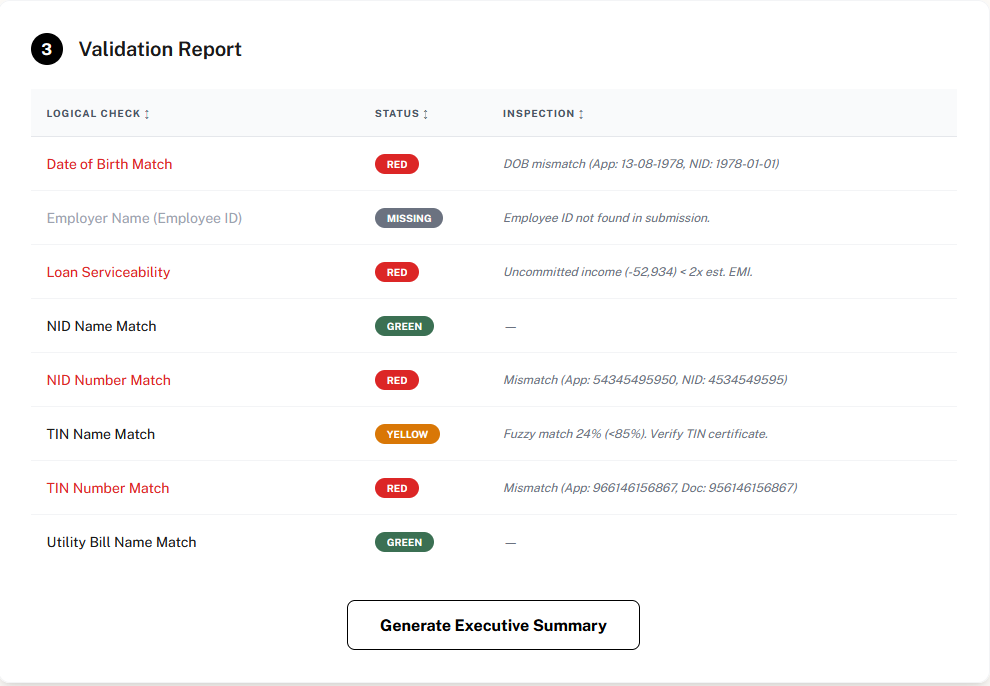

## Output 2: LLM-Based Summary

For the LLM-based summary, the text-only version of Qwen is used. This summary is memo-like in nature, meaning a banker can take a glance and recognize the most crucial problems to focus on.

In [ ]:
def build_validation_summary(vdf):

    priority_order = ["Red", "Yellow", "Green", "Missing"]
    lines = []
    for status in priority_order:
        subset = vdf[vdf["Status"] == status]
        if subset.empty:
            continue
        lines.append(f"[{status.upper()}]")
        for _, row in subset.iterrows():
            insp = row.get("Inspection", "")
            entry = f"- {row['Logical Check']}"
            if insp:
                entry += f": {insp}"
            lines.append(entry)
    findings = "\n".join(lines)

    counts = vdf["Status"].value_counts().to_dict()
    stats = ", ".join(f"{k}: {v}" for k, v in counts.items())

    prompt = (
        "You are a senior credit analyst reviewing a loan application. "
        "Below are automated validation findings grouped by severity "
        "(Red = critical, Yellow = needs attention, Green = passed, Missing = data unavailable).\n\n"
        f"Validation counts — {stats}\n\n"
        f"{findings}\n\n"
        "Write an executive summary under 100 words. "
        "Address Red issues first with the most urgency, then briefly mention the issues flagged as 'missing'. "
        "In the end, just list the issues under yellow."
        "Use a professional, concise tone suitable for a credit committee memo. "
        "Trim any introductory/concluding fat."
    )

    messages = [{"role": "user", "content": [{"type": "text", "text": prompt}]}]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], padding=True, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=400)
    generated_ids = [out[len(ins):] for ins, out in zip(inputs.input_ids, output_ids)]
    summary = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    del inputs, output_ids, generated_ids
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return summary

# --- Run ---
print("Generating LLM validation summary...\n")
summary = build_validation_summary(validation_df)
print("=" * 80)
print("EXECUTIVE SUMMARY")
print("=" * 80)
print(summary)

Generating LLM validation summary...

EXECUTIVE SUMMARY
Executive Summary:
Critical issues identified include NID number mismatch, date of birth discrepancy, and uncommitted income below twice estimated EMI. Immediate verification of NID card and cross-referencing with NID details are necessary. A deep-dive serviceability check is required due to the low income. Missing data points include employee ID and CIB reports. Fuzzy TIN name match and single inflow spike require further investigation.


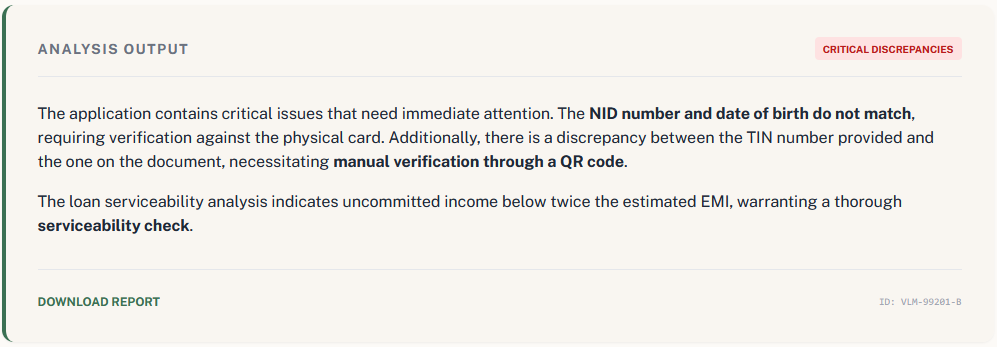

# Conclusion

In real life, many pain points exist in loan validation, and document-backed verification is only one of them.

This project does not address issues such as voice-based data collection or document integrity issues. The scope has been kept simple for demonstrative purposes. The goal was to deliver the idea that a modular, flexible validation pipeline is highly achievable. If someone wants to add a new persona or validation logic, the entire code won't fall apart. Only a few additions in certain places will do the trick.

**Generative AI was consulted for these specific purposes:**
1. Using HTML to create mock loan documents and reproduce them for synthetic aliases.
2. Troubleshooting code errors in general.
3. Learning and utilizing libraries I newly learned about (e.g. Torch, Difflib).
4. Optimizing code to fit everything in limited GPU VRAM.
5. Generating talking code for long operations to find exact issue points.